In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 유저 테이블
accounts_user_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_user.parquet")

# 탈퇴 유저
accounts_userwithdraw_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_userwithdraw.parquet")

# 투표 기록
accounts_userquestionrecord_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_userquestionrecord.parquet")

# 유저 신고 기록
accounts_timelinereport_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_timelinereport.parquet")

# 질문 세트
polls_questionset_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/polls_questionset.parquet")


In [4]:
# 1. 탈퇴 상태 제외한 유저만 남기기
valid_user_df = accounts_user_df[
    accounts_user_df['ban_status'] != 'withdrawn'  # 실제 값 확인 후 조정 필요
].copy()


# 2. 신고된 유저 제거 + 차단 상태(B) 제거한 유효 투표
reported_user_ids = accounts_timelinereport_df['reported_user_id'].unique()
valid_vote_df = accounts_userquestionrecord_df[
    (~accounts_userquestionrecord_df['user_id'].isin(reported_user_ids)) &
    (accounts_userquestionrecord_df['status'] != 'B')
].copy()

# 3. 질문 참여율 계산용 신고자 제외
valid_questionset_df = polls_questionset_df[
    ~polls_questionset_df['user_id'].isin(reported_user_ids)
].copy()


#### 누적 가입자 수 계산 

In [6]:
print("accounts_user_df:", accounts_user_df.columns)
print("accounts_userquestionrecord_df:", accounts_userquestionrecord_df.columns)
print("polls_questionset_df:", polls_questionset_df.columns)


accounts_user_df: Index(['id', 'is_superuser', 'is_staff', 'gender', 'point', 'friend_id_list',
       'is_push_on', 'created_at', 'block_user_id_list', 'hide_user_id_list',
       'ban_status', 'report_count', 'alarm_count', 'pending_chat',
       'pending_votes', 'group_id'],
      dtype='object')
accounts_userquestionrecord_df: Index(['id', 'status', 'created_at', 'chosen_user_id', 'question_id',
       'user_id', 'question_piece_id', 'has_read', 'answer_status',
       'answer_updated_at', 'report_count', 'opened_times'],
      dtype='object')
polls_questionset_df: Index(['id', 'question_piece_id_list', 'opening_time', 'status', 'created_at',
       'user_id'],
      dtype='object')


In [8]:
# accounts_user_df의 'id'를 'user_id'로 바꿔줌
accounts_user_df = accounts_user_df.rename(columns={'id': 'user_id'})

In [10]:
# 탈퇴자 제외
valid_user_df = accounts_user_df[accounts_user_df['ban_status'] != 'withdrawn'].copy()
valid_user_df['date'] = pd.to_datetime(valid_user_df['created_at']).dt.date

daily_signup_series = valid_user_df.groupby('date')['user_id'].nunique().sort_index()
cumulative_signup_series = daily_signup_series.cumsum()


#### 일별 투표한 유저 수 계산

In [25]:
# 신고당한 유저 id 목록
reported_user_ids = accounts_timelinereport_df['reported_user_id'].unique()

# 유효한 투표 기록: 신고자 제외 & 차단된 투표(status == 'B') 제외
valid_vote_df = accounts_userquestionrecord_df[
    (~accounts_userquestionrecord_df['user_id'].isin(reported_user_ids)) &
    (accounts_userquestionrecord_df['status'] != 'B')
].copy()

# 날짜 파생
valid_vote_df['date'] = pd.to_datetime(valid_vote_df['created_at']).dt.date

# 일별 유니크 투표자 수
daily_voter_series = valid_vote_df.groupby('date')['user_id'].nunique().sort_index()

daily_voter_series

date
2023-04-28    125
2023-04-29    220
2023-04-30    322
2023-05-01    324
2023-05-02    411
             ... 
2024-05-03      1
2024-05-05      1
2024-05-06      1
2024-05-07      2
2024-05-08      1
Name: user_id, Length: 267, dtype: int64

#### 질문 참여 유저 수 집계

In [26]:
# 신고당한 유저 제거
valid_questionset_df = polls_questionset_df[
    ~polls_questionset_df['user_id'].isin(reported_user_ids)
].copy()

# 날짜 파생
valid_questionset_df['date'] = pd.to_datetime(valid_questionset_df['created_at']).dt.date

# 일별 유니크 질문 참여자 수
daily_asker_series = valid_questionset_df.groupby('date')['user_id'].nunique().sort_index()

daily_asker_series

date
2023-04-28    135
2023-04-29    235
2023-04-30    332
2023-05-01    323
2023-05-02    437
             ... 
2024-04-22      1
2024-05-03      1
2024-05-05      1
2024-05-06      1
2024-05-07      3
Name: user_id, Length: 261, dtype: int64

#### 비율 

In [13]:
# 투표율: 일별 투표 유저 수 / 일별 누적 가입자 수
vote_rate_series = (daily_voter_series / cumulative_signup_series).fillna(0)
vote_rate_series.name = 'vote_rate'

# 질문 참여율: 일별 질문 참여자 수 / 일별 누적 가입자 수
question_participation_rate_series = (daily_asker_series / cumulative_signup_series).fillna(0)
question_participation_rate_series.name = 'question_participation_rate'


#### 최종 통합 결과

In [14]:
summary_df = pd.concat([
    daily_voter_series.rename('daily_voters'),
    daily_asker_series.rename('daily_askers'),
    cumulative_signup_series.rename('cumulative_signups'),
    vote_rate_series,
    question_participation_rate_series
], axis=1).fillna(0)

summary_df.head()

,daily_voters,daily_askers,cumulative_signups,vote_rate,question_participation_rate
date,,,,,
2023-04-28,125.0,135.0,9794,0.012763,0.013784
2023-04-29,220.0,235.0,14007,0.015706,0.016777
2023-04-30,322.0,332.0,19093,0.016865,0.017389
2023-05-01,324.0,323.0,23733,0.013652,0.013610
2023-05-02,411.0,437.0,27804,0.014782,0.015717


<Axes: title={'center': '일별 투표율 & 질문 참여율 추이'}, xlabel='date'>

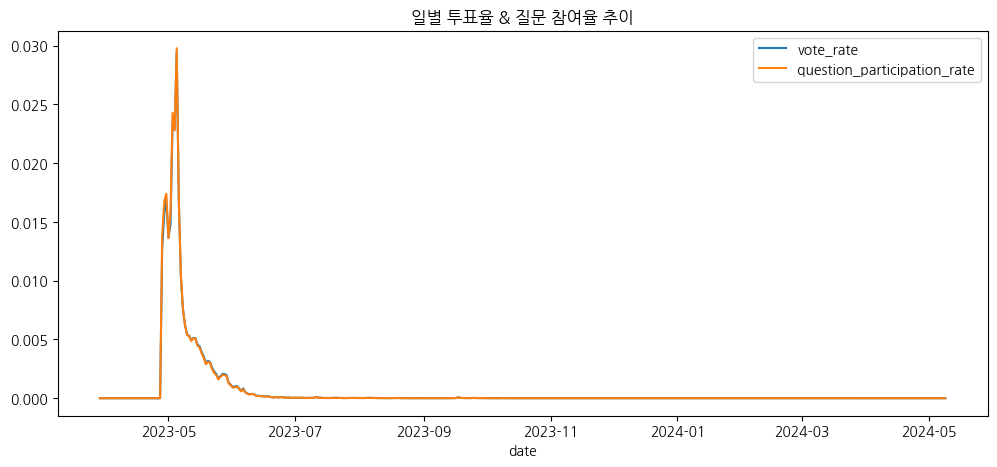

In [15]:
summary_df[['vote_rate', 'question_participation_rate']].plot(
    figsize=(12,5), title='일별 투표율 & 질문 참여율 추이'
)

In [ ]:
# 날짜 필터 범위 지정
start_date = pd.to_datetime('2023-05-01').date()
end_date = pd.to_datetime('2023-07-31').date()

# 모든 시리즈에 날짜 필터 적용
daily_voter_series = daily_voter_series.loc[start_date:end_date]
daily_asker_series = daily_asker_series.loc[start_date:end_date]
cumulative_signup_series = cumulative_signup_series.loc[start_date:end_date]


In [29]:
vote_rate_series = (daily_voter_series / cumulative_signup_series).fillna(0)
vote_rate_series.name = 'vote_rate'

question_participation_rate_series = (daily_asker_series / cumulative_signup_series).fillna(0)
question_participation_rate_series.name = 'question_participation_rate'


In [30]:
summary_df = pd.concat([
    daily_voter_series.rename('daily_voters'),
    daily_asker_series.rename('daily_askers'),
    cumulative_signup_series.rename('cumulative_signups'),
    vote_rate_series,
    question_participation_rate_series
], axis=1).fillna(0)

summary_df


,daily_voters,daily_askers,cumulative_signups,vote_rate,question_participation_rate
date,,,,,
2023-05-01,324,323,23733,0.013652,0.013610
2023-05-02,411,437,27804,0.014782,0.015717
2023-05-03,752,778,32035,0.023474,0.024286
2023-05-04,814,809,35508,0.022924,0.022784
2023-05-05,1232,1246,41842,0.029444,0.029779
...,...,...,...,...,...
2023-07-27,14,13,673090,0.000021,0.000019
2023-07-28,14,15,673121,0.000021,0.000022
2023-07-29,17,14,673146,0.000025,0.000021


<Axes: title={'center': '[5~7월] 일별 투표율 & 질문 참여율 추이'}, xlabel='date'>

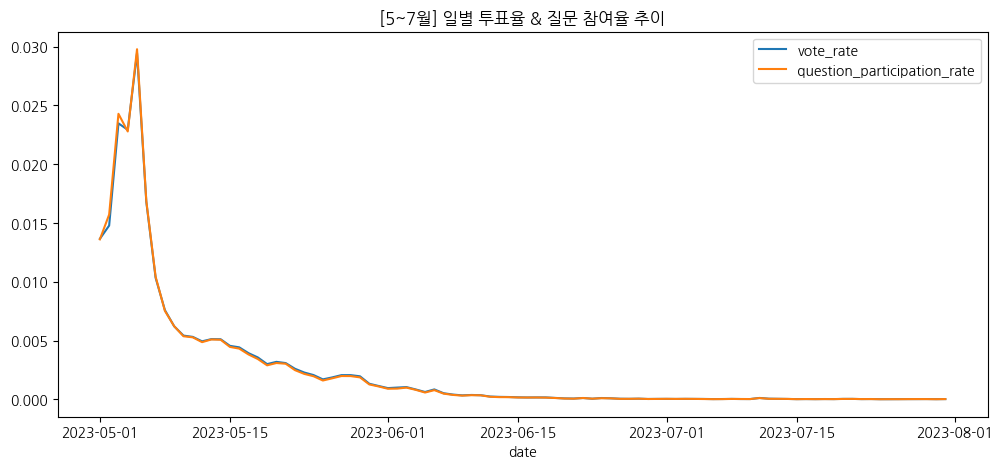

In [20]:
summary_df[['vote_rate', 'question_participation_rate']].plot(
    figsize=(12,5), title='[5~7월] 일별 투표율 & 질문 참여율 추이'
)

<Axes: title={'center': '[5~7월] 7일 이동 평균 - 투표율 & 질문 참여율'}, xlabel='date'>

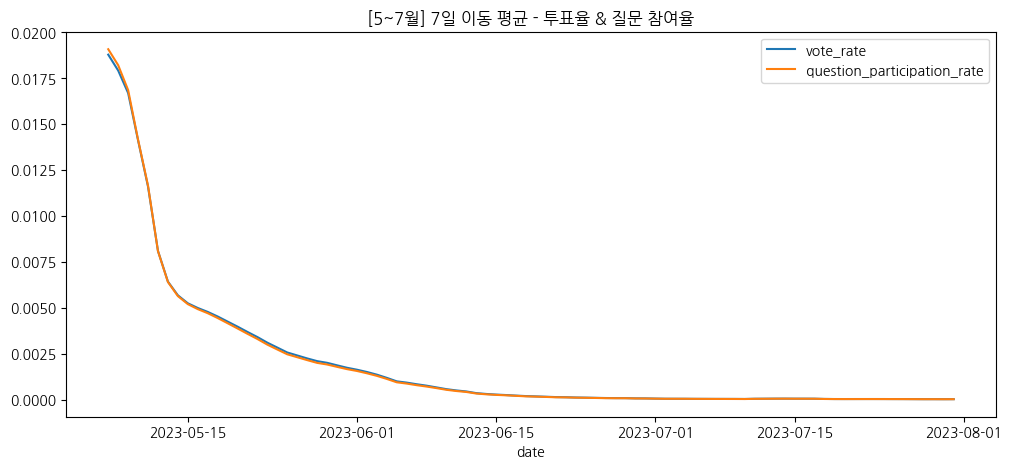

In [22]:
summary_df[['vote_rate', 'question_participation_rate']].rolling(7).mean().plot(
    figsize=(12,5), title='[5~7월] 7일 이동 평균 - 투표율 & 질문 참여율'
)

Text(2023-05-05, 0.029444099230438316, '2.94%')

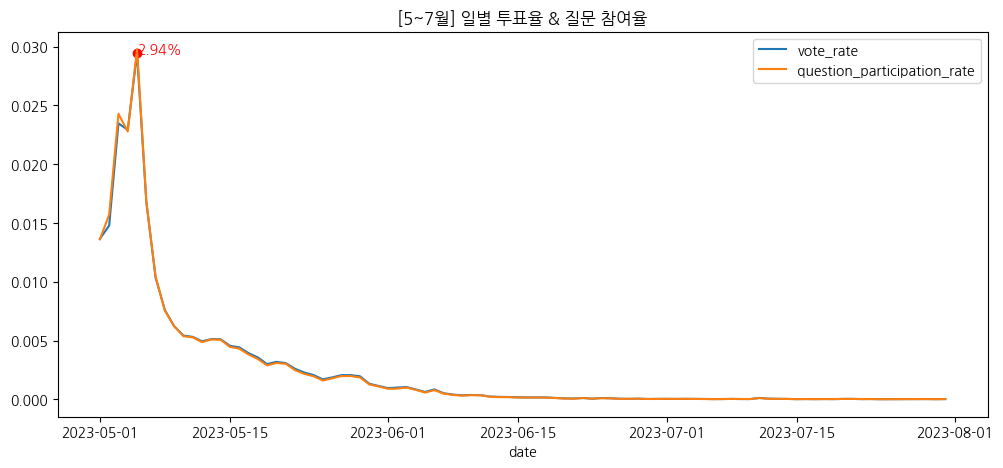

In [24]:
max_vote_date = summary_df['vote_rate'].idxmax()
max_vote_value = summary_df['vote_rate'].max()

import matplotlib.pyplot as plt
ax = summary_df[['vote_rate', 'question_participation_rate']].plot(figsize=(12,5))
plt.title('[5~7월] 일별 투표율 & 질문 참여율')
plt.scatter(max_vote_date, max_vote_value, color='red')
plt.text(max_vote_date, max_vote_value, f"{max_vote_value:.2%}", color='red', ha='left')


In [33]:
vote_rate_df = pd.read_csv('gs://final_project_enuyu/data/final_project/votes/vote_rate_table.csv')

vote_rate_df

,day,count_user,count_vote,ratio
0,2023-05-01,16679,324.0,1.9426
1,2023-05-02,20847,411.0,1.9715
2,2023-05-03,24450,752.0,3.0757
3,2023-05-04,28252,814.0,2.8812
4,2023-05-05,31322,1232.0,3.9333
...,...,...,...,...
87,2023-07-27,611933,14.0,0.0023
88,2023-07-28,611848,14.0,0.0023
89,2023-07-29,611750,17.0,0.0028
90,2023-07-30,611648,11.0,0.0018


In [32]:
vote_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   day         92 non-null     object 
 1   count_user  92 non-null     int64  
 2   count_vote  92 non-null     float64
 3   ratio       92 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.0+ KB


In [ ]:
# 투표 기록
accounts_userquestionrecord_df = pd.read_parquet("gs://final_project_enuyu/data/final_project/votes/accounts_userquestionrecord.parquet")